# Cleaning

In [1]:
import pandas as pd
import numpy as np
from os import getcwd
path=getcwd()
df_1 = pd.read_csv(path+'/../data/data_for_modeling.csv')
real_testing = pd.read_csv(path+'/../data/real_data_for_testing.csv')
df_1 = df_1.iloc[:,1:]
real_testing = real_testing.iloc[:,1:7]
df_1.head()


,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature,Datetime – BR,chuva
0,38.0,31.366,9412,0,45123,30,2020-09-30 20:00:00-03:00,0.0
1,38.5,31.366,9412,0,45025,31,2020-09-30 21:00:00-03:00,0.0
2,39.0,31.366,9419,0,44923,31,2020-09-30 22:00:00-03:00,0.0
3,39.0,31.322,9419,0,44825,31,2020-09-30 23:00:00-03:00,0.0
4,38.0,31.240,9416,0,44728,31,2020-10-01 00:00:00-03:00,0.0


In [2]:
Y_exp = df_1['chuva'].set_axis(df_1['Datetime – BR'])
X_exp = df_1.set_index('Datetime – BR').drop('chuva',axis=1)
X_exp.head()

,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature
Datetime – BR,,,,,,
2020-09-30 20:00:00-03:00,38.0,31.366,9412,0,45123,30
2020-09-30 21:00:00-03:00,38.5,31.366,9412,0,45025,31
2020-09-30 22:00:00-03:00,39.0,31.366,9419,0,44923,31
2020-09-30 23:00:00-03:00,39.0,31.322,9419,0,44825,31
2020-10-01 00:00:00-03:00,38.0,31.240,9416,0,44728,31


In [3]:
Y_exp.head()

Datetime – BR
2020-09-30 20:00:00-03:00    0.0
2020-09-30 21:00:00-03:00    0.0
2020-09-30 22:00:00-03:00    0.0
2020-09-30 23:00:00-03:00    0.0
2020-10-01 00:00:00-03:00    0.0
Name: chuva, dtype: float64

In [4]:
real_testing.head()

,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature
0,96.0,18.82,9428,3,34723,17
1,94.0,19.36,9417,3,34665,18
2,95.0,18.84,9423,3,34608,18
3,96.0,18.62,9429,3,34552,18
4,96.0,18.48,9433,3,34496,18


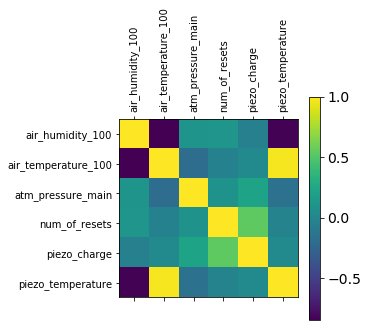

In [5]:
import matplotlib.pyplot as plt
plt.matshow(X_exp.corr())
plt.xticks(range(X_exp.select_dtypes(['number']).shape[1]), X_exp.select_dtypes(['number']).columns,rotation=90)
plt.yticks(range(X_exp.select_dtypes(['number']).shape[1]), X_exp.select_dtypes(['number']).columns)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()


In [6]:
### Code from https://github.com/vcerqueira/blog/blob/main/src/tde.py
import re
#import pandas as pd
#import numpy as np

def time_delay_embedding(series: pd.Series,
                         n_lags: int,
                         horizon: int,
                         return_Xy: bool = False):
    """
    Time delay embedding
    Time series for supervised learning

    :param series: time series as pd.Series
    :param n_lags: number of past values to used as explanatory variables
    :param horizon: how many values to forecast
    :param return_Xy: whether to return the lags split from future observations

    :return: pd.DataFrame with reconstructed time series
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    df_list = [series.shift(i) for i in n_lags_iter]
    df = pd.concat(df_list, axis=1).dropna()
    df.columns = [f'{name}(t-{j - 1})'
                  if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                  for j in n_lags_iter]

    df.columns = [re.sub('t-0', 't', x) for x in df.columns]

    if not return_Xy:
        return df

    is_future = df.columns.str.contains('\+')

    X = df.iloc[:, ~is_future]
    Y = df.iloc[:, is_future]
    if Y.shape[1] == 1:
        Y = Y.iloc[:, 0]

    return X, Y

In [7]:
cols=X_exp.drop('num_of_resets',axis=1).columns
cols2=real_testing.drop('num_of_resets',axis=1).columns
print(cols)
print(cols2)

Index(['air_humidity_100', 'air_temperature_100', 'atm_pressure_main',
       'piezo_charge', 'piezo_temperature'],
      dtype='object')
Index(['air_humidity_100', 'air_temperature_100', 'atm_pressure_main',
       'piezo_charge', 'piezo_temperature'],
      dtype='object')


In [8]:
num_reset = X_exp['num_of_resets']
index_group = X_exp.groupby('num_of_resets').cumcount(ascending=True)
trans_aux = X_exp.groupby('num_of_resets')[cols]
mean_,median_,min_, max_ = trans_aux.transform('mean'),trans_aux.transform('median'),trans_aux.transform('min'), trans_aux.transform('max')
X_exp['piezo_charge' + '_scale'] = (X_exp[cols[3]] - min_.iloc[:,3]) / (max_.iloc[:,3] - min_.iloc[:,3])


In [9]:
real_testing.head()

,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature
0,96.0,18.82,9428,3,34723,17
1,94.0,19.36,9417,3,34665,18
2,95.0,18.84,9423,3,34608,18
3,96.0,18.62,9429,3,34552,18
4,96.0,18.48,9433,3,34496,18


In [10]:
num_reset_real = real_testing['num_of_resets']
index_group_real = real_testing.groupby('num_of_resets').cumcount(ascending=True)
trans_aux_real = real_testing.groupby('num_of_resets')[cols2]
min_real, max_real =trans_aux_real.transform('min'), trans_aux_real.transform('max')
real_testing['piezo_charge' + '_scale'] = (real_testing[cols2[3]] - min_real.iloc[:,3]) / (max_real.iloc[:,3] - min_real.iloc[:,3])


In [11]:
real_testing = real_testing.drop('num_of_resets',axis=1)

In [12]:
trans_aux_real

In [13]:
real_testing.head()

,air_humidity_100,air_temperature_100,atm_pressure_main,piezo_charge,piezo_temperature,piezo_charge_scale
0,96.0,18.82,9428,34723,17,1.000000
1,94.0,19.36,9417,34665,18,0.995966
2,95.0,18.84,9423,34608,18,0.992002
3,96.0,18.62,9429,34552,18,0.988108
4,96.0,18.48,9433,34496,18,0.984213


In [14]:
X_exp.head()

,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature,piezo_charge_scale
Datetime – BR,,,,,,,
2020-09-30 20:00:00-03:00,38.0,31.366,9412,0,45123,30,1.000000
2020-09-30 21:00:00-03:00,38.5,31.366,9412,0,45025,31,0.996521
2020-09-30 22:00:00-03:00,39.0,31.366,9419,0,44923,31,0.992901
2020-09-30 23:00:00-03:00,39.0,31.322,9419,0,44825,31,0.989422
2020-10-01 00:00:00-03:00,38.0,31.240,9416,0,44728,31,0.985979


In [15]:
X = X_exp.drop('num_of_resets',axis=1)
X_col = ['piezo_charge','piezo_temperature','piezo_charge_scale']
Y = Y_exp

In [16]:
X.head()

,air_humidity_100,air_temperature_100,atm_pressure_main,piezo_charge,piezo_temperature,piezo_charge_scale
Datetime – BR,,,,,,
2020-09-30 20:00:00-03:00,38.0,31.366,9412,45123,30,1.000000
2020-09-30 21:00:00-03:00,38.5,31.366,9412,45025,31,0.996521
2020-09-30 22:00:00-03:00,39.0,31.366,9419,44923,31,0.992901
2020-09-30 23:00:00-03:00,39.0,31.322,9419,44825,31,0.989422
2020-10-01 00:00:00-03:00,38.0,31.240,9416,44728,31,0.985979


In [17]:
real_testing.head()

,air_humidity_100,air_temperature_100,atm_pressure_main,piezo_charge,piezo_temperature,piezo_charge_scale
0,96.0,18.82,9428,34723,17,1.000000
1,94.0,19.36,9417,34665,18,0.995966
2,95.0,18.84,9423,34608,18,0.992002
3,96.0,18.62,9429,34552,18,0.988108
4,96.0,18.48,9433,34496,18,0.984213


In [18]:
X['Pos_group'] = index_group
real_testing['Pos_group'] = index_group_real
cols_aux=[]
cols_aux2=[]
for col in X_col:
    print(col)
    col_df = time_delay_embedding(X[col], n_lags=3, horizon=0)
    cols_aux.append(col_df)
    col_df2 = time_delay_embedding(real_testing[col], n_lags=3, horizon=0)
    cols_aux2.append(col_df2)
X_aux = pd.concat(cols_aux, axis=1).dropna()
real_testing_aux = pd.concat(cols_aux2, axis=1).dropna()

piezo_charge
piezo_temperature
piezo_charge_scale


In [19]:
real_testing_aux.head()

,piezo_charge(t-2),piezo_charge(t-1),piezo_charge(t),piezo_temperature(t-2),piezo_temperature(t-1),piezo_temperature(t),piezo_charge_scale(t-2),piezo_charge_scale(t-1),piezo_charge_scale(t)
3,34723.0,34665.0,34608.0,17.0,18.0,18.0,1.000000,0.995966,0.992002
4,34665.0,34608.0,34552.0,18.0,18.0,18.0,0.995966,0.992002,0.988108
5,34608.0,34552.0,34496.0,18.0,18.0,18.0,0.992002,0.988108,0.984213
6,34552.0,34496.0,34441.0,18.0,18.0,18.0,0.988108,0.984213,0.980388
7,34496.0,34441.0,34389.0,18.0,18.0,17.0,0.984213,0.980388,0.976772


In [20]:
X_aux.index = X_exp.index[2:1531]
X_aux.head()

,piezo_charge(t-2),piezo_charge(t-1),piezo_charge(t),piezo_temperature(t-2),piezo_temperature(t-1),piezo_temperature(t),piezo_charge_scale(t-2),piezo_charge_scale(t-1),piezo_charge_scale(t)
Datetime – BR,,,,,,,,,
2020-09-30 22:00:00-03:00,45123.0,45025.0,44923.0,30.0,31.0,31.0,1.000000,0.996521,0.992901
2020-09-30 23:00:00-03:00,45025.0,44923.0,44825.0,31.0,31.0,31.0,0.996521,0.992901,0.989422
2020-10-01 00:00:00-03:00,44923.0,44825.0,44728.0,31.0,31.0,31.0,0.992901,0.989422,0.985979
2020-10-01 01:00:00-03:00,44825.0,44728.0,44632.0,31.0,31.0,30.0,0.989422,0.985979,0.982572
2020-10-01 02:00:00-03:00,44728.0,44632.0,44537.0,31.0,30.0,30.0,0.985979,0.982572,0.979200


In [21]:
X_aux.iloc[:,0] = X_aux.iloc[:,0] - X_aux.iloc[:,2]
X_aux.iloc[:,1] = X_aux.iloc[:,1] - X_aux.iloc[:,2]

X_aux.iloc[:,3] = X_aux.iloc[:,3] - X_aux.iloc[:,5]
X_aux.iloc[:,4] = X_aux.iloc[:,4] - X_aux.iloc[:,5]

X_aux.iloc[:,6] = X_aux.iloc[:,6] - X_aux.iloc[:,8]
X_aux.iloc[:,7] = X_aux.iloc[:,7] - X_aux.iloc[:,8]

real_testing_aux.iloc[:,0] = real_testing_aux.iloc[:,0] - real_testing_aux.iloc[:,2]
real_testing_aux.iloc[:,1] = real_testing_aux.iloc[:,1] - real_testing_aux.iloc[:,2]

real_testing_aux.iloc[:,3] = real_testing_aux.iloc[:,3] - real_testing_aux.iloc[:,5]
real_testing_aux.iloc[:,4] = real_testing_aux.iloc[:,4] - real_testing_aux.iloc[:,5]

real_testing_aux.iloc[:,6] = real_testing_aux.iloc[:,6] - real_testing_aux.iloc[:,8]
real_testing_aux.iloc[:,7] = real_testing_aux.iloc[:,7] - real_testing_aux.iloc[:,8]

In [22]:
real_testing_aux

,piezo_charge(t-2),piezo_charge(t-1),piezo_charge(t),piezo_temperature(t-2),piezo_temperature(t-1),piezo_temperature(t),piezo_charge_scale(t-2),piezo_charge_scale(t-1),piezo_charge_scale(t)
3,115.0,57.0,34608.0,-1.0,0.0,18.0,0.007998,0.003964,0.992002
4,113.0,56.0,34552.0,0.0,0.0,18.0,0.007859,0.003895,0.988108
5,112.0,56.0,34496.0,0.0,0.0,18.0,0.007789,0.003895,0.984213
6,111.0,55.0,34441.0,0.0,0.0,18.0,0.007720,0.003825,0.980388
7,107.0,52.0,34389.0,1.0,1.0,17.0,0.007441,0.003616,0.976772
...,...,...,...,...,...,...,...,...,...
174,117.0,57.0,20723.0,2.0,1.0,18.0,0.008137,0.003964,0.026358
175,111.0,54.0,20669.0,2.0,1.0,17.0,0.007720,0.003755,0.022602
176,117.0,63.0,20606.0,-1.0,-2.0,19.0,0.008137,0.004381,0.018221
177,140.0,77.0,20529.0,-8.0,-6.0,25.0,0.009736,0.005355,0.012866


In [23]:
Y = Y_exp[2:1531]
X = X.drop(X_col,axis=1)
X = X[2:1531]
real_testing = real_testing[3:179]

In [24]:
print(real_testing.shape)
print(real_testing_aux.shape)

(176, 7)
(176, 9)


In [25]:
X = pd.concat([X,X_aux],axis=1)
real_testing = pd.concat([real_testing,real_testing_aux],axis=1)

In [26]:
real_testing.head()

,air_humidity_100,air_temperature_100,atm_pressure_main,piezo_charge,piezo_temperature,piezo_charge_scale,Pos_group,piezo_charge(t-2),piezo_charge(t-1),piezo_charge(t),piezo_temperature(t-2),piezo_temperature(t-1),piezo_temperature(t),piezo_charge_scale(t-2),piezo_charge_scale(t-1),piezo_charge_scale(t)
3,96.0,18.62,9429,34552,18,0.988108,3,115.0,57.0,34608.0,-1.0,0.0,18.0,0.007998,0.003964,0.992002
4,96.0,18.48,9433,34496,18,0.984213,4,113.0,56.0,34552.0,0.0,0.0,18.0,0.007859,0.003895,0.988108
5,97.0,18.68,9440,34441,18,0.980388,5,112.0,56.0,34496.0,0.0,0.0,18.0,0.007789,0.003895,0.984213
6,97.0,18.28,9445,34389,17,0.976772,6,111.0,55.0,34441.0,0.0,0.0,18.0,0.007720,0.003825,0.980388
7,85.0,22.54,9451,34332,18,0.972808,7,107.0,52.0,34389.0,1.0,1.0,17.0,0.007441,0.003616,0.976772


In [27]:
print(X.shape)
print(Y.shape)

(1529, 13)
(1529,)


# Training models

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.ensemble import RandomForestRegressor
np.random.seed(31415)
#RandomForestRegressor
# train/test split
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X, Y, test_size=0.3, shuffle=False)

# fitting a RF model
model = RandomForestRegressor(n_estimators=20,
                             max_depth=5,
                             criterion='squared_error')
model.fit(X_tr, Y_tr)

# getting forecasts for the test set
preds = model.predict(X_ts)

# computing MAE error
print("Before:")
print(mae(Y_ts, preds))
# getting importance scores from previous model
importance_scores = pd.Series(dict(zip(X_tr.columns, model.feature_importances_)))

# getting top 10 features
top_10_features = importance_scores.sort_values(ascending=False)[:10]
top_10_features_nm = top_10_features.index

X_tr_top = X_tr[top_10_features_nm]
X_ts_top = X_ts[top_10_features_nm]

model_top_features = RandomForestRegressor(n_estimators=20,
                             max_depth=5,
                             criterion='squared_error')
model_top_features.fit(X_tr_top, Y_tr)

# getting forecasts for the test set
preds_topf = model_top_features.predict(X_ts_top)

# computing MAE error
print("After:")
print(mae(Y_ts, preds_topf))

print("\n Top ten features:")
print(top_10_features)

Before:
0.12912021856272168
After:
0.1375190165749157

 Top ten features:
piezo_charge(t-1)          0.352813
piezo_charge_scale(t-1)    0.143793
piezo_charge(t)            0.108679
piezo_charge(t-2)          0.085153
air_humidity_100           0.069406
piezo_temperature(t)       0.058535
air_temperature_100        0.051298
piezo_temperature(t-1)     0.041750
piezo_temperature(t-2)     0.024810
piezo_charge_scale(t)      0.022673
dtype: float64


In [29]:
from sklearn.linear_model import LinearRegression


# fitting a Linear model
model = LinearRegression()
model.fit(X_tr, Y_tr)

# getting forecasts for the test set
preds = model.predict(X_ts)

# computing MAE error
print("Before:")
print(mae(Y_ts, preds))
# getting importance scores from previous model
importance_scores = pd.Series(dict(zip(X_tr.columns, model.coef_)))

# getting top 10 features
top_10_features = importance_scores.sort_values(ascending=False)[:10]
top_10_features_nm = top_10_features.index

X_tr_top = X_tr[top_10_features_nm]
X_ts_top = X_ts[top_10_features_nm]

model_top_features = LinearRegression()
model_top_features.fit(X_tr_top, Y_tr)

# getting forecasts for the test set
preds_topf = model_top_features.predict(X_ts_top)

# computing MAE error
print("After:")
print(mae(Y_ts, preds_topf))

print("\n Top ten features:")
print(top_10_features)


Before:
0.2923604172711147
After:
0.28154282581895546

 Top ten features:
piezo_charge_scale(t-2)    1.809686
piezo_charge_scale(t-1)    1.059781
piezo_temperature(t-1)     0.019133
piezo_temperature(t)       0.010142
air_humidity_100           0.006433
air_temperature_100        0.002811
atm_pressure_main          0.001613
piezo_charge(t)            0.000002
piezo_charge(t-1)         -0.000022
piezo_charge(t-2)         -0.000038
dtype: float64


In [30]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# define the pipeline and train model
model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=False))])
                  
model.fit(X_tr, Y_tr)

# getting forecasts for the test set
preds = model.predict(X_ts)

# computing MAE error
print("Before:")
print(mae(Y_ts, preds))
# getting importance scores from previous model
importance_scores = pd.Series(dict(zip(X_tr.columns,model.named_steps['linear'].coef_)))

# getting top 10 features
top_10_features = importance_scores.sort_values(ascending=False)[:10]
top_10_features_nm = top_10_features.index

X_tr_top = X_tr[top_10_features_nm]
X_ts_top = X_ts[top_10_features_nm]

model_top_features = LinearRegression()
model_top_features.fit(X_tr_top, Y_tr)

# getting forecasts for the test set
preds_topf = model_top_features.predict(X_ts_top)

# computing MAE error
print("After:")
print(mae(Y_ts, preds_topf))

print("\n Top ten features:")
print(top_10_features)


Before:
26.367231451802578
After:
0.26558303183824294

 Top ten features:
piezo_charge(t)            2.161293
piezo_temperature(t)       1.676654
piezo_temperature(t-1)     0.568848
Pos_group                  0.182603
atm_pressure_main          0.149086
piezo_temperature(t-2)     0.000049
piezo_charge(t-2)         -0.024740
air_temperature_100       -0.227278
piezo_charge(t-1)         -0.670822
piezo_charge_scale(t-2)   -2.178194
dtype: float64


# Best Model

In [31]:
#Reproducing Best Model - Random Forest
from sklearn.metrics import accuracy_score
# fitting a RF model
model = RandomForestRegressor(n_estimators=20,
                             max_depth=5,
                             criterion='squared_error')
model.fit(X_tr, Y_tr)



# getting importance scores from previous model
importance_scores = pd.Series(dict(zip(X_tr.columns, model.feature_importances_)))

# getting top 10 features
top_10_features = importance_scores.sort_values(ascending=False)[:10]
top_10_features_nm = top_10_features.index

X_tr_top = X_tr[top_10_features_nm]
X_ts_top = X_ts[top_10_features_nm]

model_top_features = RandomForestRegressor(n_estimators=20,
                             max_depth=5,
                             criterion='squared_error')
model_top_features.fit(X_tr_top, Y_tr)


RandomForestRegressor(max_depth=5, n_estimators=20)

## Testing in the real data

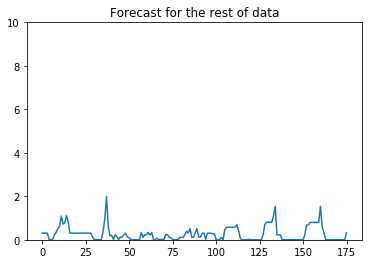

In [39]:
import matplotlib.pyplot as plt 
Y_real = model_top_features.predict(real_testing[top_10_features_nm])
Y_copy = Y_real.copy()
Y_copy[Y_copy<1e-3] = 0

plt.plot(Y_copy)
plt.ylim(0,10)
plt.title("Forecast for the rest of data")
plt.show()

## Saving the model

In [41]:
import joblib

joblib.dump(model_top_features, 'model.pkl')



['model.pkl']